# Lab work 2 : Logistic regression

This notebook builds on the fourth lecture of Foundations of Machine Learning. We'll focus on the logistic regression model and how to handle class imbalance.

Important note: the steps shown here are not always the most efficient or the most “industry-approved.” Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

We will try to accurately predict if a star observation is actually a [pulsars](https://en.wikipedia.org/wiki/Pulsar) on a [dataset](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). Let's first load the dataset.

In [ ]:
import pandas as pd

df = pd.read_csv("NB4 - Pulsars.csv")
df.head()

,Mean,Std,Excess_kurtosis,Skewness,target
0,140.562500,55.683782,-0.234571,-0.699648,0
1,102.507812,58.882430,0.465318,-0.515088,0
2,103.015625,39.341649,0.323328,1.051164,0
3,136.750000,57.178449,-0.068415,-0.636238,0
4,88.726562,40.672225,0.600866,1.123492,0


As we are working on a classification problem, one need first to measure how imbalanced are classes.

**Task**: Measure class imbalance on the dataset by measuring how often the target is the interest modality (here 1).

In [2]:
imbalance_rate = 100 * df["target"].mean()
print(f"Interest class rate: {imbalance_rate:.2f}%")

Interest class rate: 9.16%


Therefore, a model with accuracy below 90% is a model performing worst than a model predicting "it is not a pulsar" everytime. Beyond the difficulty in measuring performance, there is also a problem in the splitting process :

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train)")
imbalance_rate_test = 100 * y_test.mean()
print(f"Interest class rate: {imbalance_rate_test:.2f}% (test)")

Interest class rate: 9.19% (train)
Interest class rate: 9.05% (test)


The [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function split randomly the dataset, therefore doesn't preserve the imbalance across splits.
To overcome this, one can use the *stratify* parameter.

**Task** : Modify the code above to use the *stratify* parameter and conclude.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train)")
imbalance_rate_test = 100 * y_test.mean()
print(f"Interest class rate: {imbalance_rate_test:.2f}% (test)")

Interest class rate: 9.16% (train)
Interest class rate: 9.16% (test)


## Data preparation

As always, the bread and butter of data science : data preparation.

**Task** : Inspect the dataset with the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) method as every column are numerical.

In [5]:
df.describe()

,Mean,Std,Excess_kurtosis,Skewness,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,0.091574
std,25.652935,6.843189,1.064040,6.167913,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,0.000000
50%,115.078125,46.947479,0.223240,0.198710,0.000000
75%,127.085938,51.023202,0.473325,0.927783,0.000000
max,192.617188,98.778911,8.069522,68.101622,1.000000


**Task** : Given the code below, using [`scatter_matrix`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) function, interpret its output for our problem.

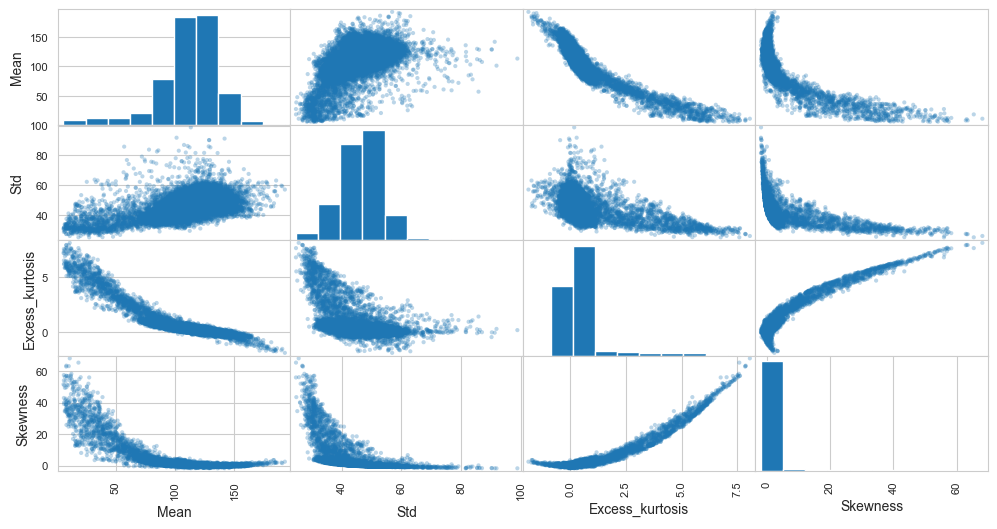

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")

X = df.drop(columns=["target"])
pd.plotting.scatter_matrix(X, figsize=(12, 6), alpha=0.3)
plt.show()

This figure gives a lot of insights, but it doesn't show the proper repartition of the two classes.

**Task** : Using the function below, explore again the different relationship between the variables and the target.

In [7]:
def scatter_classification(df, target_column, column_1, column_2, figsize=(12, 6), **kwargs):
    plt.figure(figsize=figsize)
    for index, value in enumerate(df[target_column].unique()):
        subset = df.loc[df["target"] == value, ]
        plt.scatter(subset[column_1], subset[column_2], color=sns.color_palette()[index], label=f"Class {index}", **kwargs)
    plt.title(f"{column_1} vs {column_2}")
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.legend()
    plt.show()

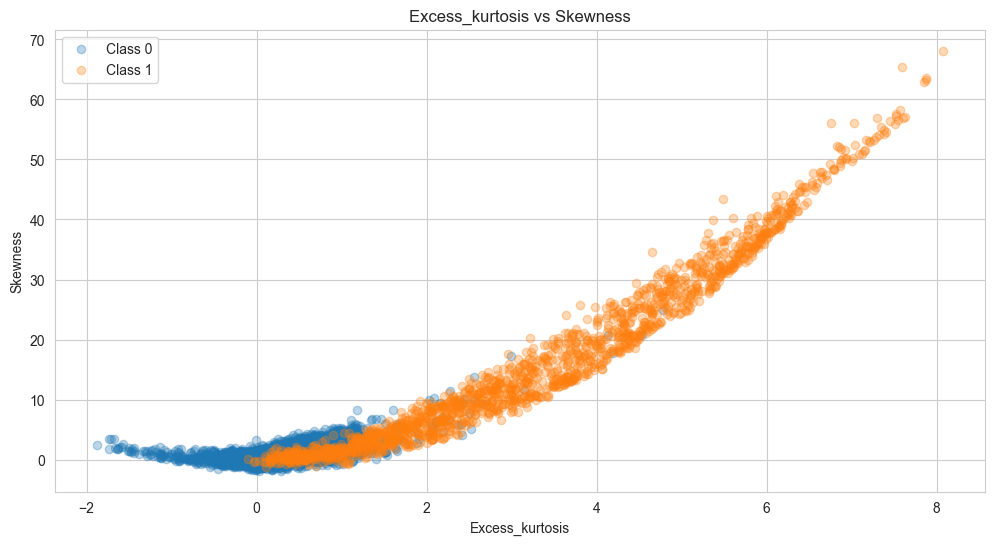

In [8]:
scatter_classification(df, "target", "Excess_kurtosis", "Skewness", alpha=0.3)

We clearly get that : Skewness = Excess_kurtosis ** 2. Therefore, we decide to remove the Excess_kurtosis variable from our work.
Also, given the name of the column *Mean* and *Std*, we decide to compute the *Z-Score* variable defined as the ratio between the two.

**Task** : Implement the changes detailled above.

In [9]:
df = df.drop(columns=["Excess_kurtosis"])
df["Z-Score"] = df["Mean"] / df["Std"]

Now is time model !

## Modelisation and pipeline

Logistic regression learns its coefficient using variants of gradient descent. Therefore it requires a standardisation of its feature to stabilize the training.

**Task** : Using the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) class, train a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) after splitting with the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function carefully.
Then, display performance metric such as accuracy, precision, recall and F1-Score. One can use the [`precision_recall_fscore_support`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) function.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Accuracy: 0.9741
Precision: 0.9682
Recall: 0.7415
F1-Score: 0.8398


The performance are already quite good, as expected ! We are performing two steps to train :
1. Learn and then standardize the inputs
2. Train

We are also performing two steps to predict :
1. Standardize the input, using the learning in the training
2. Predict

This two use case are very similar : the can be combined using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. Its goal is to simplify the code, as follow :

In [11]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Accuracy: 0.9741
Precision: 0.9682
Recall: 0.7415
F1-Score: 0.8398


We highly encourage to use the Pipeline class in order to prevent data leakage with the StandardScaler.

## Choosing the right threshold

We know that a logistic regression output natively a score interpreted as a probability. Then is it transformed into classes (0 / 1) using the threshold 0.5
What if this wasn't the best threshold for the F1-Score ?

**Task** : Compute for several thresholds the precision, recall and F1-Score value. Then make a plot highlighting where the best performance is achieved.

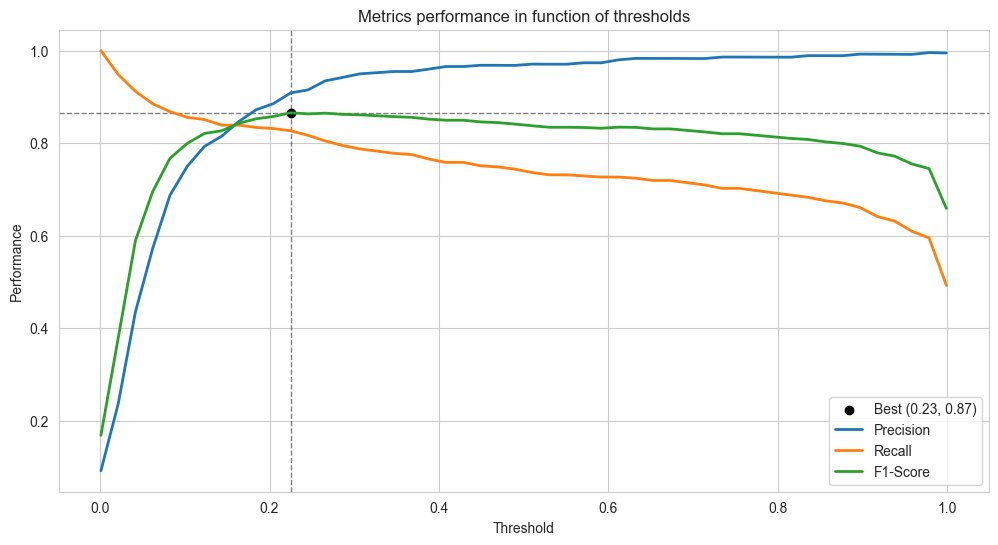

In [12]:
import numpy as np

def plot_thresholds_performances(y_pred_proba, title=None, figsize=(12, 6)):
    thresholds = np.linspace(start=0.001, stop=0.999, num=50)
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        y_pred = y_pred_proba > threshold
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    string = f"Best ({best_threshold:.2f}, {f1_scores[best_index]:.2f})"

    plt.figure(figsize=figsize)
    plt.scatter([best_threshold], [f1_scores[best_index]], color="black", label=string)
    plt.axvline(x=best_threshold, ls='--', lw=1, alpha=0.5, color="black")
    plt.axhline(y=f1_scores[best_index], ls='--', lw=1, alpha=0.5, color="black")

    plt.plot(thresholds, precisions, label="Precision", lw=2)
    plt.plot(thresholds, recalls, label="Recall", lw=2)
    plt.plot(thresholds, f1_scores, label="F1-Score", lw=2)


    plt.xlabel("Threshold")
    plt.ylabel("Performance")
    if title is None: 
        title = "Metrics performance in function of thresholds"
    plt.title(title)

    plt.legend()
    plt.show()


y_pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_thresholds_performances(y_pred_proba)

We are going to dive deeper in some subject for the continuation of this notebook, so let's wrap useful code up.

**Task** : Define a function `train_experiment` which will fit a model given a training dataset, then test this model against a test dataset and display the metrics curves we've just wrote.

In [13]:
def train_experiment(model, X_train, X_test, y_train, y_test, title=None):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    plot_thresholds_performances(y_pred_proba, title=title)
    

## Handle imbalance

So far, apart from splitting sets and performance measure, it doesn't feel like class imbalance really bothers us as the problem seems to be *simple*. Yet this type of problem can necessitate the need for **resampling**. We are going to cover some of them.

The first is **random under sampling**. The method is going to randomly drop observations from the majority class, until the desired ratio between majority and minority class.

**Task** : Using the [`RandomUnderSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.

Interest class rate: 9.16% (train), 13423 samples
Interest class rate: 50.00% (train, resampled), 2458 samples
Accuracy: 0.9517
Precision: 0.6895
Recall: 0.8610
F1-Score: 0.7657


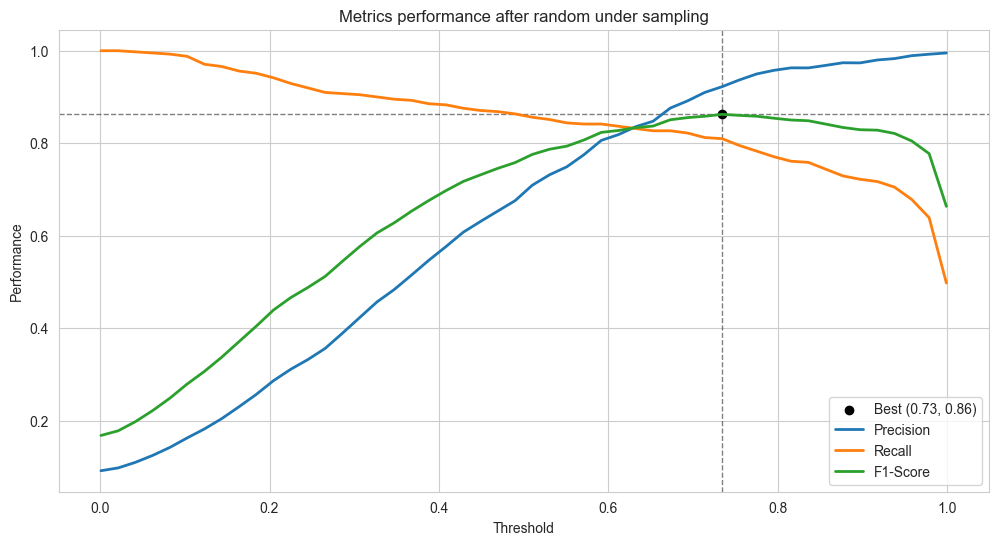

In [14]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler()
X_train_sample, y_train_sample = sampler.fit_resample(X_train, y_train)
imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train), {len(y_train)} samples")
imbalance_rate_resample = 100 * y_train_sample.mean()
print(f"Interest class rate: {imbalance_rate_resample:.2f}% (train, resampled), {len(y_train_sample)} samples")

model = LogisticRegression()
train_experiment(model, X_train_sample, X_test, y_train_sample, y_test, title="Metrics performance after random under sampling")

The second method is the opposite : we are going to duplicate observations from the minority class until the desired ratio. This is called **random over sampling**.

**Task** : Using the [`RandomOverSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.

Interest class rate: 9.16% (train), 13423 samples
Interest class rate: 50.00% (train, resampled), 24388 samples
Accuracy: 0.9593
Precision: 0.7395
Recall: 0.8585
F1-Score: 0.7946


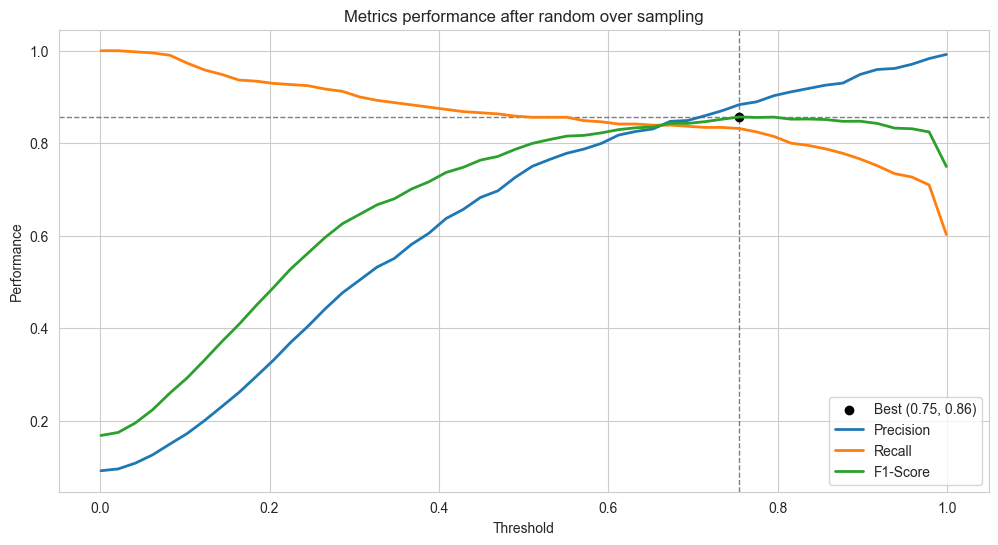

In [15]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
X_train_sample, y_train_sample = sampler.fit_resample(X_train, y_train)
imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train), {len(y_train)} samples")
imbalance_rate_resample = 100 * y_train_sample.mean()
print(f"Interest class rate: {imbalance_rate_resample:.2f}% (train, resampled), {len(y_train_sample)} samples")

model = LogisticRegression()
train_experiment(model, X_train_sample, X_test, y_train_sample, y_test, title="Metrics performance after random over sampling")

One last method that belongs to the under-sampling category is [**SMOTE**](https://www.jair.org/index.php/jair/article/view/10302/24590) (Synthetic Minority Over-sampling Technique). The algorithm is going to **create** observations based on neighbors of the future new observation. For a more visual explanation, one can look at [these slides](https://github.com/theo-lq/Conferences/blob/main/M2%20IASD%20Exec%20-%20ML%20LCLF/Support%202024.pdf) (in french).

**Task** : Using the [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.

Interest class rate: 9.16% (train), 13423 samples
Interest class rate: 50.00% (train, resampled), 24388 samples
Accuracy: 0.9607
Precision: 0.7489
Recall: 0.8585
F1-Score: 0.8000


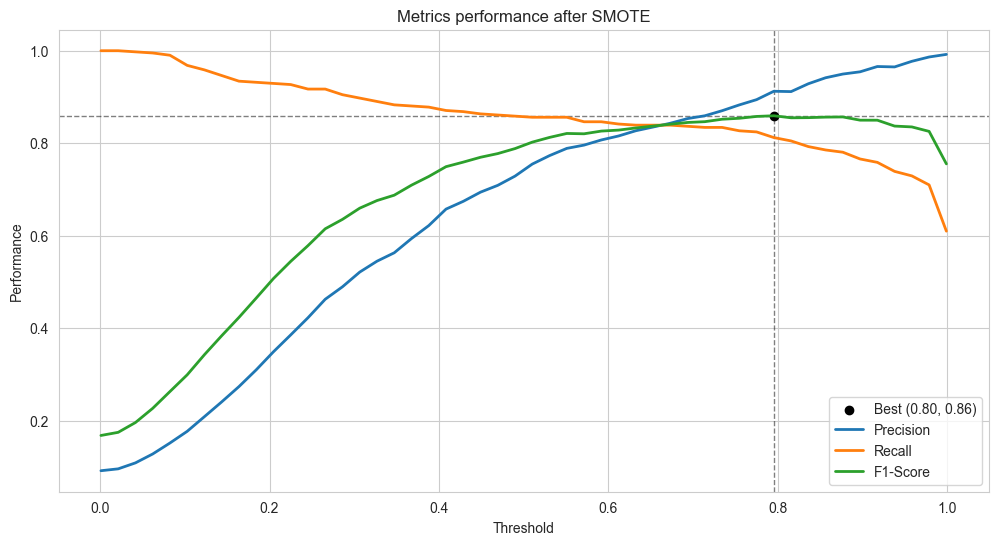

In [16]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE()
X_train_sample, y_train_sample = sampler.fit_resample(X_train, y_train)
imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train), {len(y_train)} samples")
imbalance_rate_resample = 100 * y_train_sample.mean()
print(f"Interest class rate: {imbalance_rate_resample:.2f}% (train, resampled), {len(y_train_sample)} samples")


model = LogisticRegression()
train_experiment(model, X_train_sample, X_test, y_train_sample, y_test, title="Metrics performance after SMOTE")

For our dataset and our work, balancing the dataset didn't work out in performance but change the model confidence and calibration.

Another method, not relying on balancing the dataset is to take class imbalance into the training loss.

**Task** : Using the *class_weight* parameter in the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, fit a model and display performance metrics and visuals.

Accuracy: 0.9607
Precision: 0.7489
Recall: 0.8585
F1-Score: 0.8000


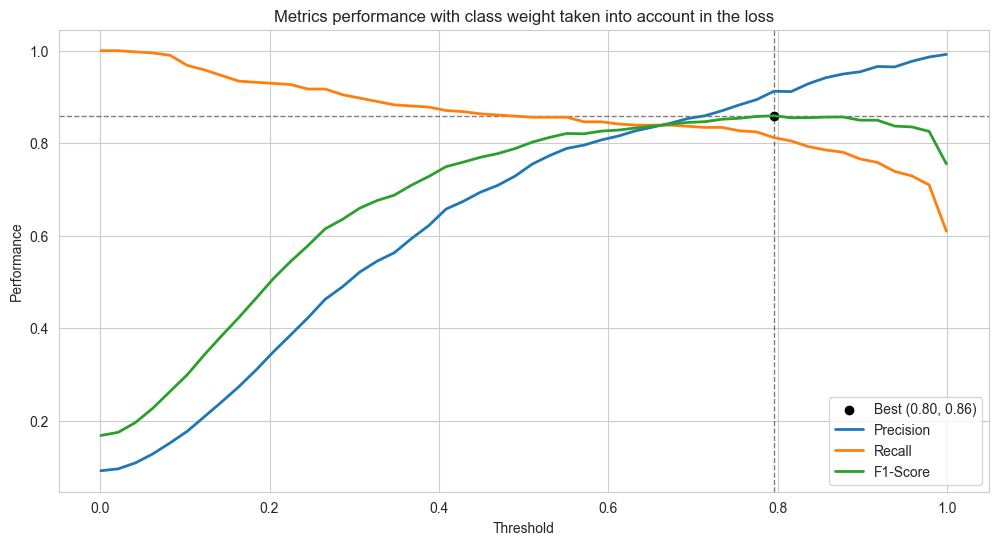

In [17]:
model = LogisticRegression(class_weight="balanced")
train_experiment(model, X_train_sample, X_test, y_train_sample, y_test, title="Metrics performance with class weight taken into account in the loss")

## Polynomial feature and hyperparameter tuning

As we have seen in session 2, polynomial features can help linear model handle complex relationships. We shoud try them again.

**Task** : Using the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) class, process the training set and transform the test set. Then, fit as usual and display performance metrics and visuals.

Accuracy: 0.9783
Precision: 0.9589
Recall: 0.7976
F1-Score: 0.8708


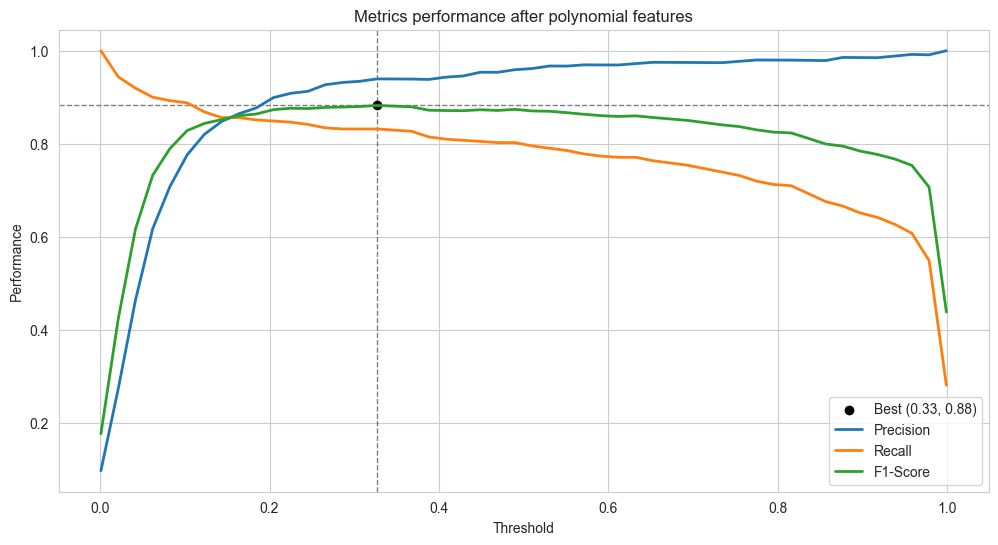

In [18]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression())
])

model = LogisticRegression()
train_experiment(model, X_train_poly, X_test_poly, y_train, y_test, title="Metrics performance after polynomial features")

It is a bit better ! There is still some work to do !